In [1]:
from datetime import datetime
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
msft = yf.download(tickers = "MSFT", 
                  start = datetime(2011, 1, 1),
                  end = datetime(2012, 12, 31))
msft.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,28.049999,28.18,27.920000,27.98,21.754162,53443800
2011-01-04,27.940001,28.17,27.850000,28.09,21.839689,54405600
2011-01-05,27.900000,28.01,27.770000,28.00,21.769722,58998700
2011-01-06,28.040001,28.85,27.860001,28.82,22.407263,88026300
2011-01-07,28.639999,28.74,28.250000,28.60,22.236216,73762000


BUY @price: 26.19
SELL@price: 25.67
BUY @price: 25.30
SELL@price: 24.79
BUY @price: 26.00
SELL@price: 25.44
BUY @price: 27.31
SELL@price: 26.76
BUY @price: 26.01
SELL@price: 25.49
BUY @price: 32.05
SELL@price: 31.41
BUY @price: 30.96
SELL@price: 30.30
BUY @price: 30.35
SELL@price: 29.74
BUY @price: 27.45
SELL@price: 26.90
Final Portfolio Value: 9994.89


<IPython.core.display.Javascript object>


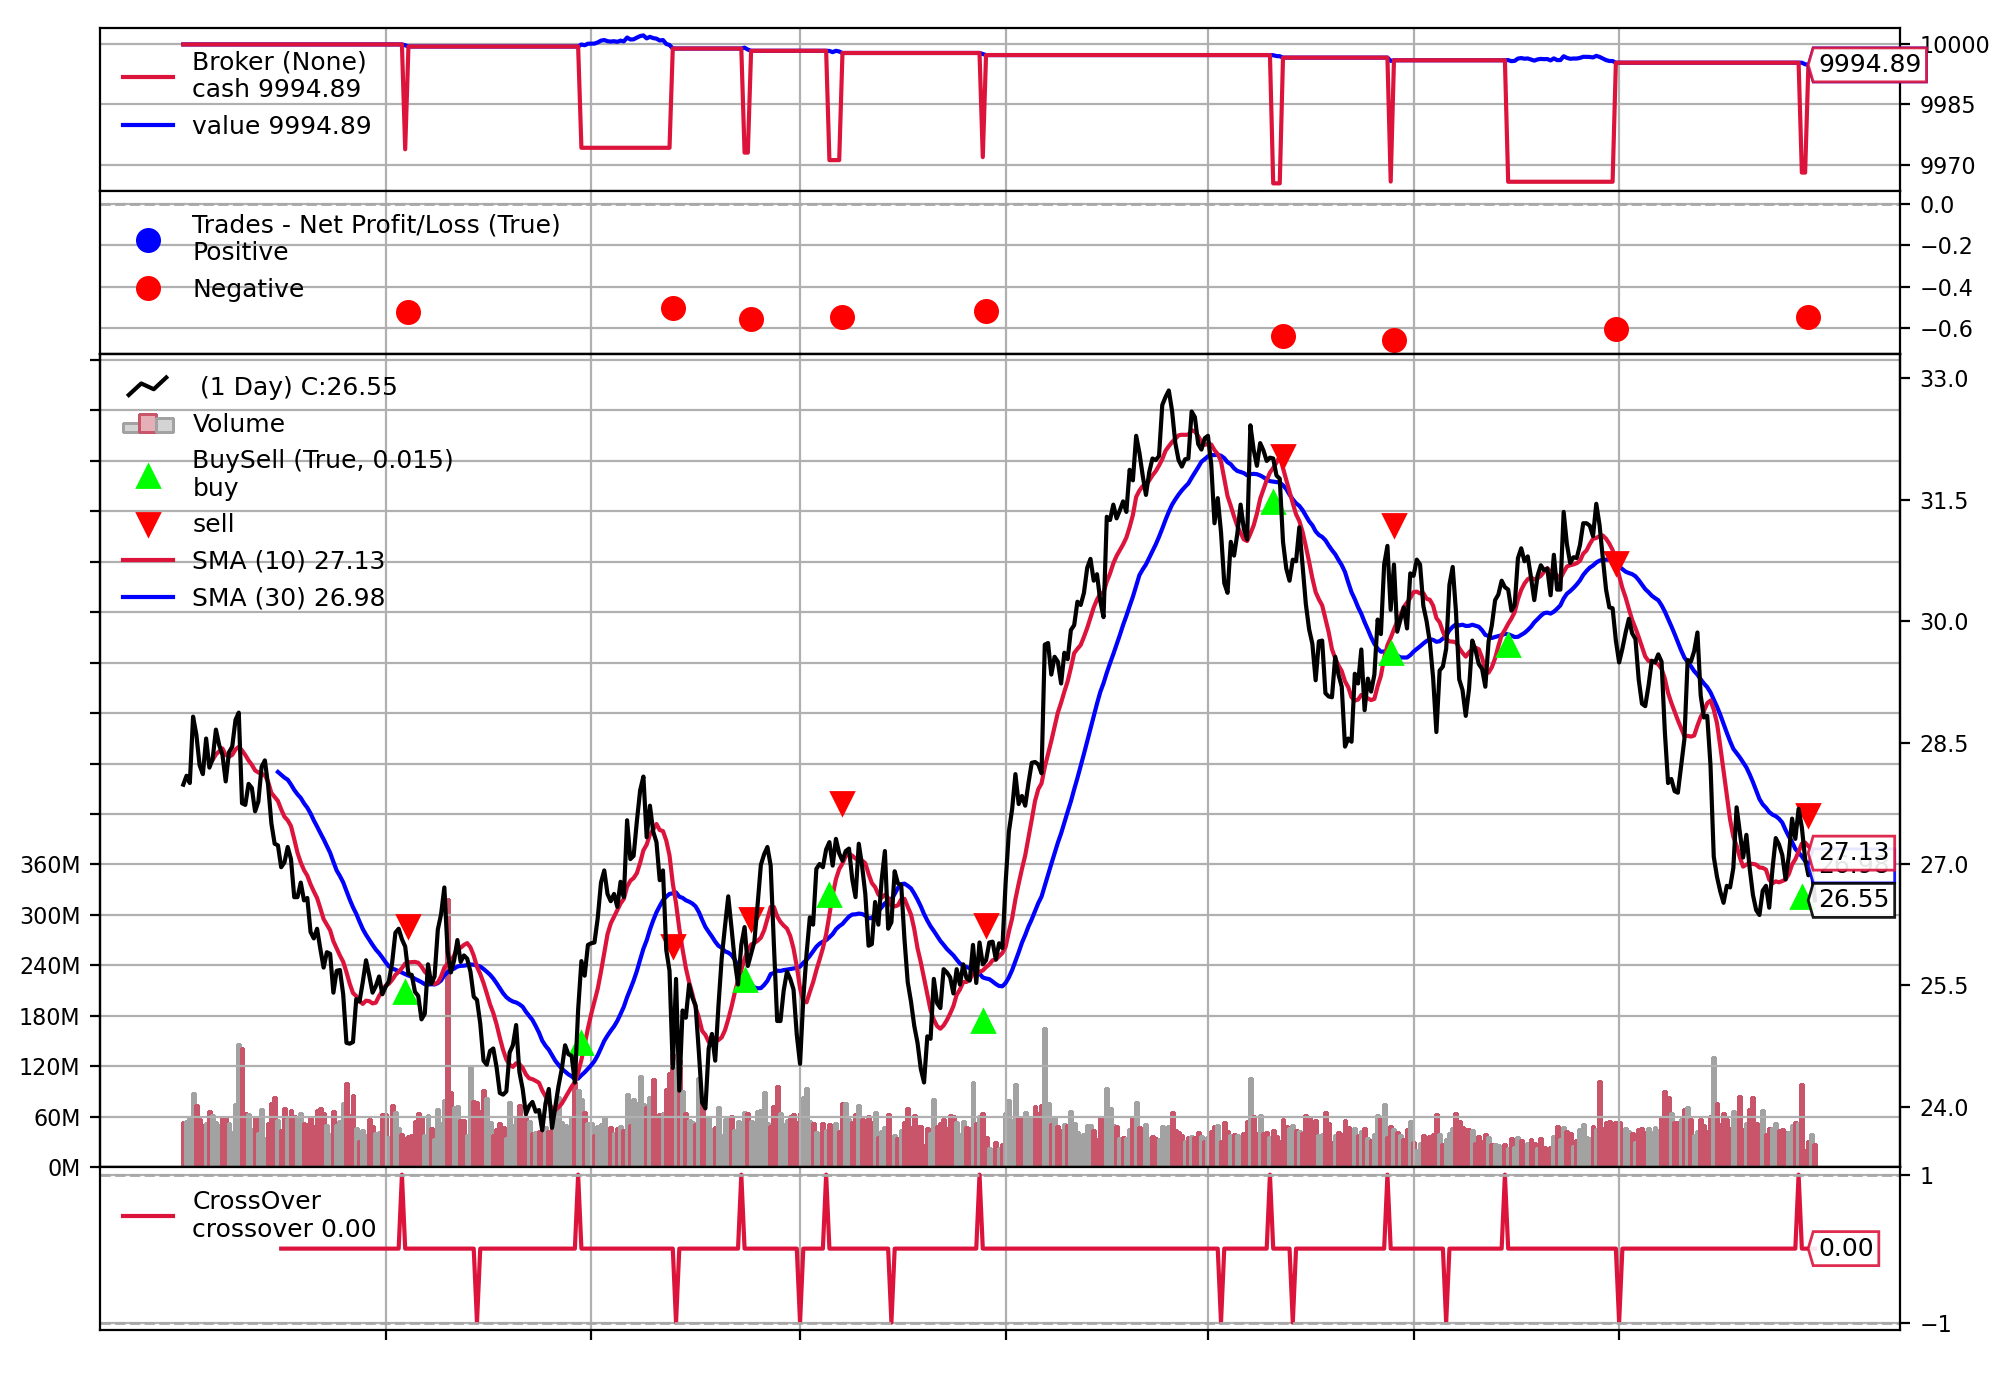

In [5]:
# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30,   # period for the slow moving average
        stop_loss=0.02,
        trail=False,
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def notify_order(self, order):
        if not order.status == order.Completed:
            return  # discard any other notification

        if not self.position:  # we left the market
            print('SELL@price: {:.2f}'.format(order.executed.price))
            return

        # We have entered the market
        print('BUY @price: {:.2f}'.format(order.executed.price))

        if not self.p.trail:
            stop_price = order.executed.price * (1.0 - self.p.stop_loss)
            self.sell(exectype=bt.Order.Stop, price=stop_price)
        else:
            self.sell(exectype=bt.Order.StopTrail, trailamount=self.p.trail)      
        
               
        
    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro()  # create a "Cerebro" engine instance
cerebro.broker.setcash(10000.0)

# Create a data feed
data = bt.feeds.PandasData(dataname = msft)

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(SmaCross)  # Add the trading strategy
cerebro.run()  # run it all

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 8}) 
cerebro.plot();  # and plot it with a single command